Matplotlb 한글 폰트 설정

In [ ]:
# Initial Setting (font, display)
!sudo apt-get install -y fonts-nanum # 글씨체 다운로드
!sudo fc-cache -fv # 폰트 리스트 갱신
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
plt.rc('font',family='NanumBarunGothic')

import matplotlib
get_ipython().run_line_magic('config',"InlineBackend.figure_format='retina'") # 화질보정

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,587 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160837 files and d

# 1. 에브리타임 게시글 데이터 크롤링

참고 사이트 : [Headless 크롬 크롤링](https://beomi.github.io/gb-crawling/posts/2017-09-28-HowToMakeWebCrawler-Headless-Chrome.html)
[Selenium 크롤링](https://beomi.github.io/gb-crawling/posts/2017-02-27-HowToMakeWebCrawler-With-Selenium.html)

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds #SVD
from string import punctuation

#NLP Preprocessing package
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
print('Ready')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Ready


## Packages for data crawling

In [ ]:
!pip install bs4 # 파이썬 크롤링 크롤러 설치
!pip install lxml # Beautiful Soup 파싱 도구를 더 잘 활용하기 위한 것

In [ ]:
!pip3 install selenium # version update가 항상 필요함.

     |████████████████████████████████| 904 kB 6.1 MB/s 


In [ ]:
#Packages for data crawling

from selenium import webdriver # 디바이스에 설치된 브라우저들을 제어할 수 있다.
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
from selenium.webdriver.common.keys import Keys
import time
import sys
import requests

# colab에서 selenium을 사용하기 위해서는 지정해줘야하는 부분
!apt-get update
!apt install chromium-chromedriver

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-securi

# 데이터 크롤링 

In [ ]:
url = 'https://everytime.kr/login'

options=webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument("--single-process")
options.add_argument("--window-size=1920,1080")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("disable-gpu")

#에브리타임에서 크롤링해오려는 경우에 참고
options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36") # User Agent 확인 : Chrome browser
driver = webdriver.Chrome('chromedriver', options=options)


delay_time = 0.5
driver.implicitly_wait(delay_time)

driver.get(url)

In [ ]:
#에브리타임 로그인 아이디/비밀번호
#각자 에브리타임의 아이디와 비밀번호를 입력해주세요!
id = "hongseoljin"
pwd = "garam8893"

In [ ]:
# 아이디, 비밀번호 접근 # ???????????
input_id=driver.find_element_by_xpath("/html/body/div/form/p[1]/input")
input_id.send_keys(id)

input_pwd=driver.find_element_by_xpath("/html/body/div/form/p[2]/input") 
input_pwd.send_keys(pwd)

In [ ]:
print(input_id,input_pwd)

<selenium.webdriver.remote.webelement.WebElement (session="7a7e839ee82d00436280a8092ed375c3", element="96280654-4643-4d2a-b175-b979abdb40f0")> <selenium.webdriver.remote.webelement.WebElement (session="7a7e839ee82d00436280a8092ed375c3", element="540db1c2-2a55-4000-be0b-a9be13b6966d")>


In [ ]:
#로그인 버튼 클릭
login = driver.find_element_by_xpath("/html/body/div/form/p[3]/input")
login.click()

In [ ]:
# Data Crawling (에브리타임 게시글 데이터)
# 게시글 데이터 담을 데이터프레임 생성
everytime_data=pd.DataFrame(columns=['post'])

# 게시글 1000개만 가져오기
# 한 페이지당 게시글 20개가 있으므로 50페이지까지 크롤링

for k in range(1,51): # 페이지 개수 설정
  for i in range(1,21): # 페이지에 있는 게시글 개수는 20개
    # 취업/진로 게시판 (다른 게시판도 가능) - 취업/진로 게시판의 경우 url 370507
    url_num=370507
    url="https://everytime.kr/370507/p/%d" % k # https://www.koreapas.com/bbs/dept.php
    driver.get(url)
    info = driver.find_elements_by_xpath("/html/body/div[2]/div[3]/article[%d]/a/h2" % i)  # "/html/body/div/div[5]/div/div/table[2]/tbody/tr[6]/td[$d]" % i

    for n in info:
      everytime_post=[]
      try:
        post=n.text # 글 제목으로 데이터 수집. ( 내용에는 불필요한 정보가 많다고 생각했음. )
        everytime_post.append(post) 
        print(post)

        new_data={'post':post}
        everytime_data=everytime_data.append(new_data,ignore_index=True)
        print('pass')
      except:
        print('error')



행정고시 고시동 경험해보신 분 있으신가요
pass
🛴디어 산업기능요원(보충역) 채용합니다🛴
pass
[스타트업 팀원 모집] 팀아이브와 함께 성장할 개발자를 구합니다!
pass
(긴급🔥)[장애학생지원센터] 근로장학생 휴학생 모집
pass
[커뮤니케이션팀] 전일제 근로장학생 모집 (휴학생 대상)
pass
안전관리팀 근로장학생 모집
pass
대학 / 학과 인터뷰 하실 분 구합니다!!
pass
[채용정보] 이랜드그룹 ESI 수시채용 인턴십 채용 ★서류마감예정(07/19~08/01)★
pass
토스페이먼츠 Tech 직군 대규모 공채!
pass
투자회사에 들어가고 싶은데
pass
[커뮤니케이션팀] 전일제 근로장학생 모집 (휴학생 대상)
pass
🔥신입 MD 채용🔥 커뮤니케이션 능력자라면 바로 지원하세요!
pass
cpa강의들 동시접속되나요??
pass
비상경 문과 학생입니다!
pass
이중전공 / 복수전공 관련 질문드립니다 !
pass
대외협력부 근로장학생 모집
pass
컴퓨터비전 랩실
pass
[채용/병특] 반도체 회로 설계 tool 스타트업 Baum 정규직 및 병역특례
pass
실무에서 쓰이는 영어공부는 어떻게 하나요?
pass
경영 이중전공 하신분들 중
pass
컴과 전공들 수강할 방법 없을까요
pass
전기전자공학부에서
pass
[전 직군 채용] 설립 10개월차, 누적 매출 60억의 스타트업인 스탁키퍼에서 TEAM-SCALE-UP을 진행합니다.
pass
미국 통계대학원으로 진학하고 싶은데요.
pass
이중전공 탈락 이유
pass
컴과 1학년 인턴
pass
지원서 학점 기입 질문드려요!!
pass
기사자격증 취득요건
pass
사회복무요원인데 군면제가 될 수 있다네요…
pass
[채용] 시너지 힐앤놀튼 해외PR/외국계PR 인턴 채용공고 (외국계기업)
pass
서울대 대학원 지망생입니다
pass
5급 피셋 학원
pass
스타트업 WEMAIN에서 앱 개발자를 모집합니다!
pass
의대
pass
회사 경력
pass
![채용] 스카이온 웹,ios 개발자,디자이너,마케터 모집

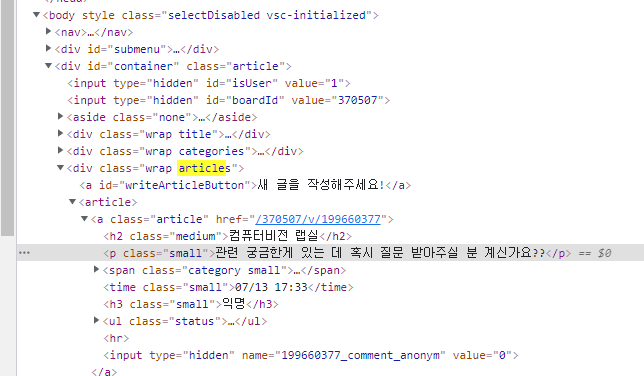

In [ ]:
#게시글이 제대로 크롤링 되어왔음을 확인하실 수 있습니다.
#상위 post 10개 확인
pd.set_option('display.max_colwidth', -1) #truncated되지 않고 post 모두 보여주기
everytime_data[:10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,post
0,행정고시 고시동 경험해보신 분 있으신가요
1,🛴디어 산업기능요원(보충역) 채용합니다🛴
2,[스타트업 팀원 모집] 팀아이브와 함께 성장할 개발자를 구합니다!
3,(긴급🔥)[장애학생지원센터] 근로장학생 휴학생 모집
4,[커뮤니케이션팀] 전일제 근로장학생 모집 (휴학생 대상)
5,안전관리팀 근로장학생 모집
6,대학 / 학과 인터뷰 하실 분 구합니다!!
7,[채용정보] 이랜드그룹 ESI 수시채용 인턴십 채용 ★서류마감예정(07/19~08/01)★
8,토스페이먼츠 Tech 직군 대규모 공채!
9,투자회사에 들어가고 싶은데


In [ ]:
df=everytime_data

# 불순어 제거 및 텍스트 데이터 전처리 

In [ ]:
!pip install konlpy

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from gensim.models.word2vec import Word2Vec

In [ ]:
df['title']=df['post'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글 제외 불순어 제거
df['title'].replace('',np.nan,inplace=True)
df.head()

,post,title
0,행정고시 고시동 경험해보신 분 있으신가요,행정고시 고시동 경험해보신 분 있으신가요
1,🛴디어 산업기능요원(보충역) 채용합니다🛴,디어 산업기능요원보충역 채용합니다
2,[스타트업 팀원 모집] 팀아이브와 함께 성장할 개발자를 구합니다!,스타트업 팀원 모집 팀아이브와 함께 성장할 개발자를 구합니다
3,(긴급🔥)[장애학생지원센터] 근로장학생 휴학생 모집,긴급장애학생지원센터 근로장학생 휴학생 모집
4,[커뮤니케이션팀] 전일제 근로장학생 모집 (휴학생 대상),커뮤니케이션팀 전일제 근로장학생 모집 휴학생 대상


In [ ]:
# 결측치로 변한 행 제거
df=df.dropna()

In [ ]:
df.head()

,post,title
0,행정고시 고시동 경험해보신 분 있으신가요,행정고시 고시동 경험해보신 분 있으신가요
1,🛴디어 산업기능요원(보충역) 채용합니다🛴,디어 산업기능요원보충역 채용합니다
2,[스타트업 팀원 모집] 팀아이브와 함께 성장할 개발자를 구합니다!,스타트업 팀원 모집 팀아이브와 함께 성장할 개발자를 구합니다
3,(긴급🔥)[장애학생지원센터] 근로장학생 휴학생 모집,긴급장애학생지원센터 근로장학생 휴학생 모집
4,[커뮤니케이션팀] 전일제 근로장학생 모집 (휴학생 대상),커뮤니케이션팀 전일제 근로장학생 모집 휴학생 대상


In [ ]:
print(df.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [ ]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
# 형태소 분석기 OKT를 사용한 토큰화 작업
okt=Okt()
tokenized_data=[]
for sentence in df['title']:
  #temp_X=okt.morphs(sentence,stem=True) # 토큰화  or Nouns? or Morphs
  temp_X=okt.nouns(sentence)
  temp_X=[word for word in temp_X if word not in stopwords] # 불용어 제거 
  tokenized_data.append(temp_X)

In [ ]:
tokenized_data

[['행정고시', '시동', '경험', '분', '가요'],
 ['디어', '산업', '기능', '요원', '보충역', '채용'],
 ['스타트업', '팀', '모집', '팀', '아이브', '개발자', '구합', '니'],
 ['긴급', '장애', '학생', '지원', '센터', '근로', '장학생', '휴학생', '모집'],
 ['커뮤니케이션', '팀', '일제', '근로', '장학생', '모집', '휴학생', '대상'],
 ['안전', '관리', '팀', '근로', '장학생', '모집'],
 ['대학', '학과', '인터뷰', '분', '구합', '니'],
 ['채용정보', '이랜드', '그룹', '수시', '채용', '인턴십', '채용', '서류', '마감', '예정'],
 ['토스', '페이', '먼츠', '직', '대규모', '공채'],
 ['투자', '회사'],
 ['커뮤니케이션', '팀', '일제', '근로', '장학생', '모집', '휴학생', '대상'],
 ['신입', '채용', '커뮤니케이션', '능력자', '라면', '바로', '지원'],
 ['강의', '접속'],
 ['비상', '경', '문과', '학생'],
 ['이중', '전공', '복수', '전공', '관련', '질문'],
 ['대외협력', '부', '근로', '장학생', '모집'],
 ['컴퓨터', '랩실'],
 ['채용', '병특', '반도체', '회로', '설계', '스타트업', '정규직', '및', '병역', '특례'],
 ['실무', '영어', '공부', '하나요'],
 ['경영', '이중', '전공', '신분', '중'],
 ['컴', '전공', '수강', '방법'],
 ['전자공학', '부'],
 ['전', '직', '채용', '설립', '개월차', '누적', '매출', '억', '스타트업', '스탁키퍼', '진행'],
 ['미국', '통계', '대학원', '진학'],
 ['이중', '전공', '탈락', '이유'],
 ['컴', '학년', '인턴'],
 ['지원', '학

In [ ]:
from gensim.models import Word2Vec
model=Word2Vec(sentences=tokenized_data,size=100,window=5,min_count=5,workers=4,sg=0)

In [ ]:
info_list=['취업','문과','컴','대기업','인턴']

for info in info_list:
  print(info,' : ',model.wv.most_similar(info))
  

취업  :  [('대기업', 0.30329105257987976), ('융전', 0.27798396348953247), ('경제학', 0.27386030554771423), ('이랜드', 0.24408210813999176), ('경공', 0.2313549518585205), ('이중', 0.20747041702270508), ('경영', 0.2053031623363495), ('준비', 0.2041686773300171), ('계획', 0.20020759105682373), ('경영학', 0.19285953044891357)]
문과  :  [('대학원', 0.2932846248149872), ('전환', 0.2620094418525696), ('관리', 0.22386299073696136), ('기업', 0.2136238068342209), ('상담', 0.20371945202350616), ('직', 0.18995937705039978), ('마케팅', 0.17837470769882202), ('식자', 0.1726062297821045), ('관련', 0.1709837019443512), ('장학생', 0.1566450297832489)]
컴  :  [('하나요', 0.3010826110839844), ('복전', 0.2922753691673279), ('컷', 0.25280898809432983), ('선배', 0.248868927359581), ('석사', 0.24715828895568848), ('학번', 0.24277301132678986), ('중', 0.23684319853782654), ('뭐', 0.23141533136367798), ('지원', 0.22690464556217194), ('인턴십', 0.20816195011138916)]
대기업  :  [('경제', 0.365595281124115), ('융전', 0.3135642111301422), ('취업', 0.30329105257987976), ('분', 0.28126096725463

# Word Cloud 생성

In [ ]:
# 토크나이징 후 명사만 추출
# konlpy로 명사만 추출하는 토큰화 진행.
from tensorflow.keras.preprocessing.text import Tokenizer

df['token']=tokenized_data
tokenizer=Tokenizer()
tokenizer.fit_on_texts(tokenized_data)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
from collections import Counter

def tokenizing(df):
  words=np.hstack(df['token'].values)
  word_count=Counter(words)
  input=dict(word_count.most_common(300))
  return input

In [ ]:
from wordcloud import WordCloud

# 토크나이징된 data frame 넣으면 워드클라우드 그려주는 함수 정의
def wcdraw(df, color):  
  df2 = tokenizing(df)
  fontpath = '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf'
  wordcloud = WordCloud(font_path = fontpath, max_words=100, colormap = color,
                      width=900,height=500, background_color ='white')
  wordcloud = wordcloud.generate_from_frequencies(df2) #빈도에 따라서 
  plt.figure(figsize = (15 , 10))
  plt.axis("off")
  plt.imshow(wordcloud)

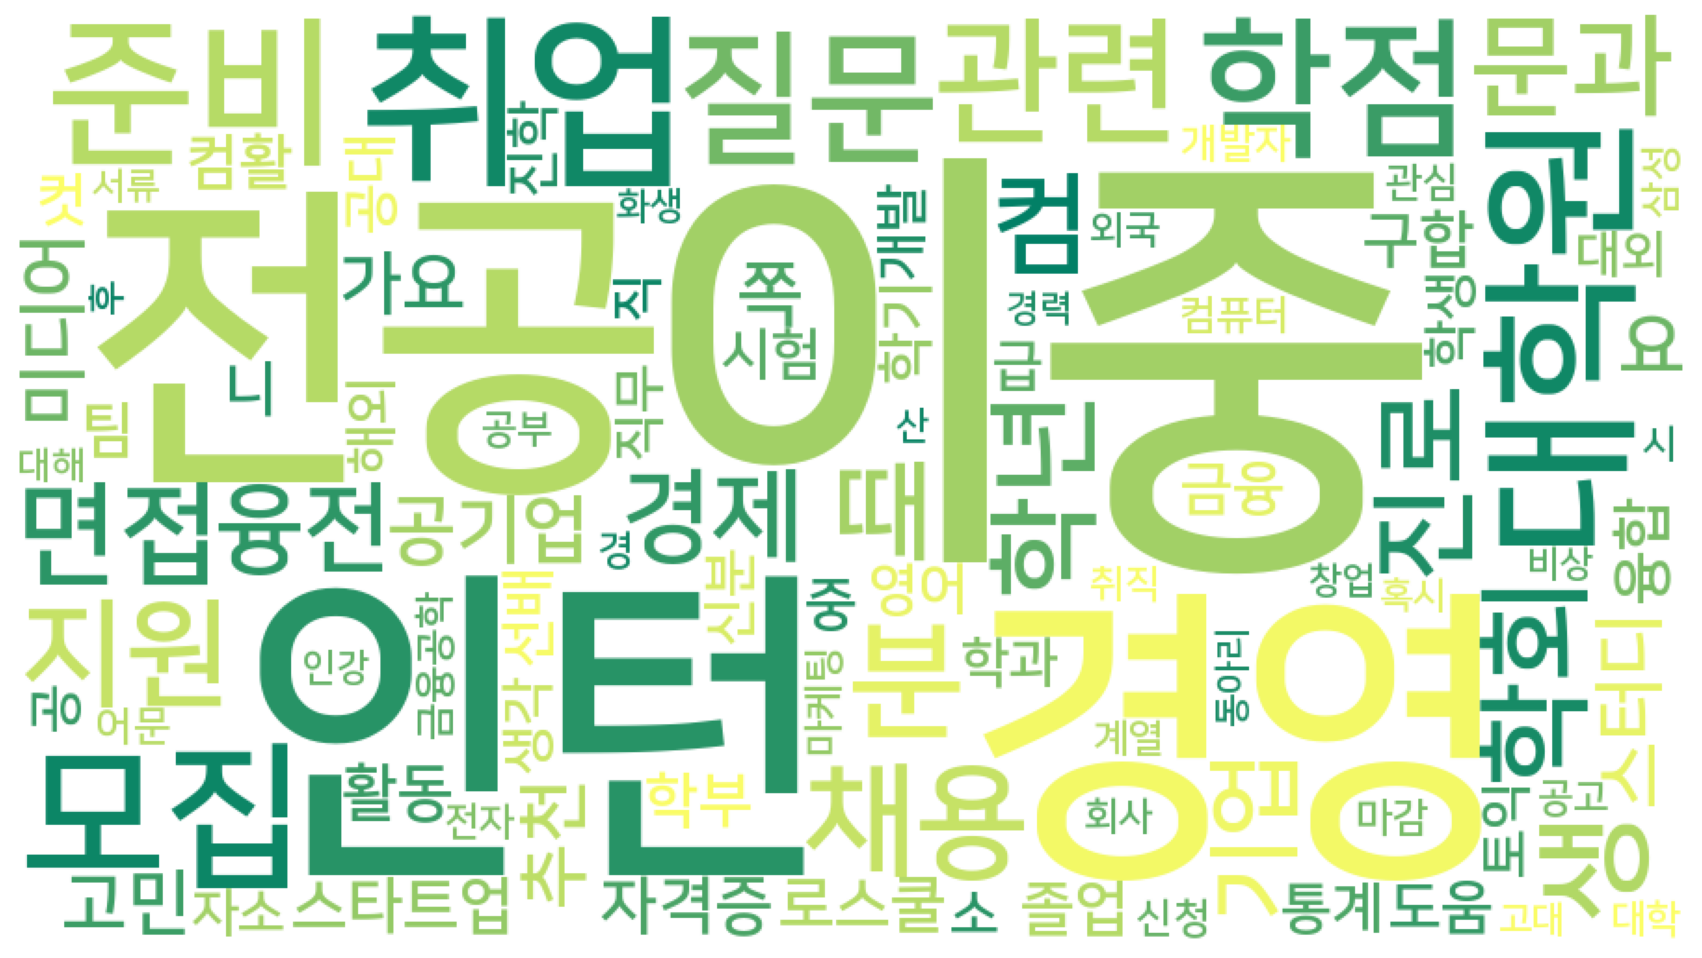

In [ ]:
wcdraw(df, 'summer')